<a href="https://colab.research.google.com/github/benthecoder/code-notebooks/blob/main/viraltweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
# essentials
import pandas as pd
import numpy as np

# misc libraries
import random
import timeit
import math 
import collections 

# surpress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid', color_codes=True)
plt.style.use('fivethirtyeight')
%matplotlib inline

# model building
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## helper functions

In [ ]:
def printColumnTypes(df):
    non_num_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(exclude=['object'])
    '''separates non-numeric and numeric columns'''
    print("Non-Numeric columns:")
    for col in non_num_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in num_df:
        print(f"{col}")

def missing_cols(df):
    '''prints out columns with its amount of missing values with its %'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += missing_vals
        if missing_vals != 0:
          print('{} => {} [{}%]'.format(col, df[col].isnull().sum(), round(pct, 2)))
    
    if total == 0:
        print("no missing values")

# Loading data

In [ ]:
# Note: this path will be different depending on where you store the dataset
tweets_path = '/content/drive/MyDrive/Colab Notebooks/viral tweets/Dataset/Tweets/'
users_path = '/content/drive/MyDrive/Colab Notebooks/viral tweets/Dataset/Users/'

# Load training datasets
train_tweets = pd.read_csv(tweets_path + 'train_tweets.csv')
train_tweets_vectorized_media = pd.read_csv(tweets_path + 'train_tweets_vectorized_media.csv')
train_tweets_vectorized_text = pd.read_csv(tweets_path + 'train_tweets_vectorized_text.csv')

# Load test dataset
test_tweets = pd.read_csv(tweets_path + 'test_tweets.csv')
test_tweets_vectorized_media = pd.read_csv(tweets_path + 'test_tweets_vectorized_media.csv')
test_tweets_vectorized_text = pd.read_csv(tweets_path + 'test_tweets_vectorized_text.csv')

# Load user dataset
users = pd.read_csv(users_path + 'users.csv')
user_vectorized_descriptions = pd.read_csv(users_path + 'user_vectorized_descriptions.csv')
user_vectorized_profile_images = pd.read_csv(users_path + 'user_vectorized_profile_images.csv')

In [ ]:
# print dimensions of data
print('Dimension of train tweets is', train_tweets.shape)
print('Dimension of train tweets vectorized media is', train_tweets_vectorized_media.shape)
print('Dimension of train tweets vectorized text is', train_tweets_vectorized_text.shape)
print()

print('Dimension of test tweets is', test_tweets.shape)
print('Dimension of test tweets vectorized media is', test_tweets_vectorized_media.shape)
print('Dimension of test tweets vectorized text is', test_tweets_vectorized_text.shape)
print()

print('Dimension of users is', users.shape)
print('Dimension of user vectorized descriptions is', user_vectorized_descriptions.shape)
print('Dimension of user vectorized profile images is', user_vectorized_profile_images.shape)
print()

Dimension of train tweets is (29625, 14)
Dimension of train tweets vectorized media is (21010, 2050)
Dimension of train tweets vectorized text is (29625, 769)

Dimension of test tweets is (12697, 13)
Dimension of test tweets vectorized media is (8946, 2050)
Dimension of test tweets vectorized text is (12697, 769)

Dimension of users is (52, 11)
Dimension of user vectorized descriptions is (52, 769)
Dimension of user vectorized profile images is (52, 2049)



# Exploratory Data Analysis

In [ ]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


In [ ]:
train_tweets_vectorized_media.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,img_feature_8,img_feature_9,img_feature_10,img_feature_11,img_feature_12,img_feature_13,img_feature_14,img_feature_15,img_feature_16,img_feature_17,img_feature_18,img_feature_19,img_feature_20,img_feature_21,img_feature_22,img_feature_23,img_feature_24,img_feature_25,img_feature_26,img_feature_27,img_feature_28,img_feature_29,img_feature_30,img_feature_31,img_feature_32,img_feature_33,img_feature_34,img_feature_35,img_feature_36,img_feature_37,...,img_feature_2008,img_feature_2009,img_feature_2010,img_feature_2011,img_feature_2012,img_feature_2013,img_feature_2014,img_feature_2015,img_feature_2016,img_feature_2017,img_feature_2018,img_feature_2019,img_feature_2020,img_feature_2021,img_feature_2022,img_feature_2023,img_feature_2024,img_feature_2025,img_feature_2026,img_feature_2027,img_feature_2028,img_feature_2029,img_feature_2030,img_feature_2031,img_feature_2032,img_feature_2033,img_feature_2034,img_feature_2035,img_feature_2036,img_feature_2037,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,0.00027,0.424207,0.000000,0.372124,0.031332,0.041069,0.000000,0.209875,0.232068,0.003567,0.185193,0.096734,0.127461,0.005552,0.000435,0.429719,0.024739,0.000051,0.000842,0.115226,0.000000,0.026856,0.000000,0.031253,0.032772,0.051137,0.026097,0.962891,0.132004,0.158875,...,0.000480,0.000000,0.018373,0.327092,0.079089,0.360097,0.002562,1.116611,0.054391,0.086378,0.045496,0.030632,0.000000,0.000000,0.000000,0.165220,0.000000,0.059310,0.111803,0.000000,0.109110,0.025834,0.235375,0.078341,0.131708,0.013988,0.000000,0.025960,0.015760,0.266088,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,0.00000,0.191951,0.003372,0.000000,0.009363,0.000000,0.000000,0.012317,0.016527,0.130308,0.000000,0.000000,0.303246,0.000000,0.307988,0.011478,0.044807,0.208410,0.043399,0.118079,0.000222,0.083115,0.000000,0.634716,0.000000,0.014040,0.090266,0.000000,0.127964,0.189758,...,0.000000,0.001796,0.000000,0.251383,0.021052,0.802314,0.027913,0.335493,0.017326,0.000000,0.026515,0.056399,0.030597,0.082174,0.003829,0.083139,0.003266,0.249968,0.304901,0.004793,0.028569,0.000000,0.069980,0.007251,0.194076,0.000000,0.124188,0.000000,0.691953,0.009337,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,0.00000,0.040884,0.009688,0.000000,0.000000,0.000000,0.074692,0.018211,0.233618,0.039807,0.000000,0.000000,0.169830,0.000000,0.045755,0.028518,0.000000,0.259838,0.117726,0.017544,0.018106,0.000000,0.019969,0.257562,0.000000,0.006338,0.000000,0.000000,0.090963,0.746206,...,0.000000,0.000000,0.032314,0.000000,0.000000,0.143607,0.371495,0.199860,0.192786,0.000000,0.401853,0.021595,0.033472,0.164238,0.085964,0.293521,0.000000,0.082590,0.020819,0.001283,0.009182,0.000000,0.295073,0.000000,0.300424,0.228981,0.109332,0.032641,0.263165,0.000992,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,0.00000,0.040679,0.027965,0.000000,0.001766,0.014541,0.000000,0.010728,0.147126,0.574918,0.000000,0.126482,0.096826,0.040340,0.005732,0.000296,0.000000,0.081848,0.000000,0.001031,0.114108,0.000000,0.000000,0.702560,0.000000,0.307037,0.290887,0.003196,0.093841,0.257387,...,0.214097,0.000000,0.004700,0.005008,0.000000,0.540658,0.035425,0.069549,0.197432,0.023377,0.010510,0.000000,0.023421,0.000000,0.029902,0.067589,0.080281,0.005246,0.000000,0.000000,0.007966,0.000000,0.064383,0.255950,0.330105,0.000000

In [ ]:
train_tweets_vectorized_text.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_728,feature_729,feature_730,feature_731,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,0.120231,-0.245443,0.199461,-0.154236,-0.200109,-0.206436,0.270252,-0.142692,-0.102078,0.157226,-0.334515,-0.264958,-0.112983,-0.293211,-0.253694,-0.104198,0.056506,-0.231244,0.152571,0.206752,-0.150545,0.112063,-0.129411,-0.224150,-0.175330,-0.165828,-0.066047,-0.159027,0.009872,0.019299,...,0.039782,-0.174679,0.148821,-0.192575,-0.114211,0.496451,0.040274,-0.142680,0.169754,-0.075535,-0.117306,0.261488,0.240786,-0.150380,-0.080656,0.310319,0.042854,0.048131,-0.172710,0.135926,-0.043390,-0.208796,0.040137,-0.190645,-0.096934,-0.009036,0.284776,0.338148,-0.440536,-0.090837,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,0.135007,-0.192705,0.252616,-0.135662,-0.201412,-0.183382,0.173640,-0.103182,-0.074723,0.234004,-0.283560,-0.120644,-0.063076,-0.248546,-0.224326,-0.176795,0.061400,-0.243843,0.226394,0.101096,-0.077593,0.057844,-0.086949,-0.239860,-0.303655,-0.223538,-0.041548,-0.162694,0.005842,0.053615,...,0.151876,-0.153876,0.272216,-0.265888,-0.124845,0.500886,-0.053478,-0.159796,0.102271,0.032116,-0.034348,0.292187,0.236578,-0.006660,-0.113676,0.249192,0.048188,-0.055551,-0.037698,0.148909,0.064823,-0.270230,0.003926,-0.207080,-0.062248,-0.056531,0.188629,0.366379,-0.511710,-0.025049,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,0.101362,-0.238145,0.173951,-0.102029,-0.181864,-0.214877,0.186110,-0.032114,-0.143620,0.175421,-0.260034,-0.103828,-0.122353,-0.316970,-0.289015,-0.215771,0.027695,-0.254362,0.160985,0.040491,-0.019251,0.156431,-0.089619,-0.204530,-0.155480,-0.207329,-0.044228,-0.094432,-0.054102,-0.069460,...,0.013487,-0.145385,0.251336,-0.243751,-0.218401,0.557650,-0.032927,-0.233999,0.107764,-0.054706,-0.151404,0.268172,0.148024,0.066601,-0.126532,0.235418,0.013908,0.107383,-0.114999,0.242328,0.062410,-0.122995,0.026454,-0.118704,-0.025266,0.015129,0.252958,0.273657,-0.522295,-0.049114,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,0.056506,-0.180725,0.183492,-0.055121,-0.205312,-0.267817,0.152828,-0.026461,-0.150457,0.253863,-0.289086,-0.194721,-0.073793,-0.313012,-0.311311,-0.254014,-0.055075,-0.147885,0.179036,0.120235,-0.005531,0.080192,-0.229052,-0.137060,-0.281633,-0.225555,-0.010621,-0.105480,-0.135987,-0.034342,...,0.058002,-0.146499,0.203021,-0.242434,-0.169852,0.488979,0.018102,-0.178110,0.155078,-0.020591,-0.145490,0.284350,0.186599,0.037712,-0.143745,0.180907,-0.023579,0.016043,-0.097705,0.168376,0.072525,-0.184797,0.048695,-0.136387,-0.102923,-0.042237,0.235340,0.317434,-0.532257,-0.036280,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084

In [ ]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                29625 non-null  int64  
 1   tweet_user_id           29625 non-null  int64  
 2   tweet_created_at_year   29625 non-null  int64  
 3   tweet_created_at_month  29625 non-null  int64  
 4   tweet_created_at_day    29625 non-null  int64  
 5   tweet_created_at_hour   29625 non-null  int64  
 6   tweet_hashtag_count     29625 non-null  float64
 7   tweet_url_count         29625 non-null  float64
 8   tweet_mention_count     29625 non-null  float64
 9   tweet_has_attachment    29625 non-null  bool   
 10  tweet_attachment_class  29625 non-null  object 
 11  tweet_language_id       29625 non-null  int64  
 12  tweet_topic_ids         25340 non-null  object 
 13  virality                29625 non-null  int64  
dtypes: bool(1), float64(3), int64(8), obje

In [ ]:
printColumnTypes(train_tweets)

Non-Numeric columns:
tweet_attachment_class
tweet_topic_ids

Numeric columns:
tweet_id
tweet_user_id
tweet_created_at_year
tweet_created_at_month
tweet_created_at_day
tweet_created_at_hour
tweet_hashtag_count
tweet_url_count
tweet_mention_count
tweet_has_attachment
tweet_language_id
virality


## train tweets features

In [ ]:
train_tweets['virality'].describe()

count    29625.000000
mean         1.907274
std          1.078700
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: virality, dtype: float64

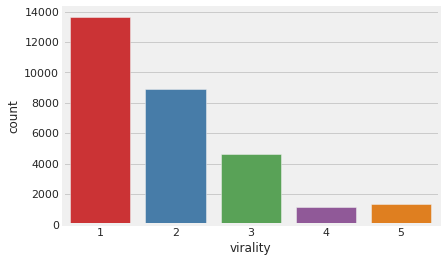

In [ ]:
sns.countplot(x = 'virality', data = train_tweets, palette="Set1");

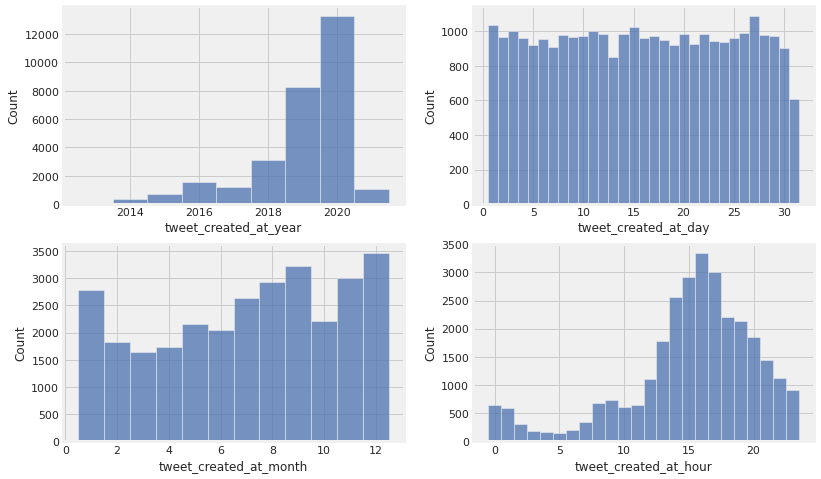

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(train_tweets, x = 'tweet_created_at_year', discrete = True, ax = axs[0,0]);
sns.histplot(train_tweets, x = 'tweet_created_at_day', discrete = True, ax = axs[0,1]);
sns.histplot(train_tweets, x = 'tweet_created_at_month', discrete = True, ax = axs[1,0]);
sns.histplot(train_tweets, x = 'tweet_created_at_hour', discrete = True, ax = axs[1,1]);

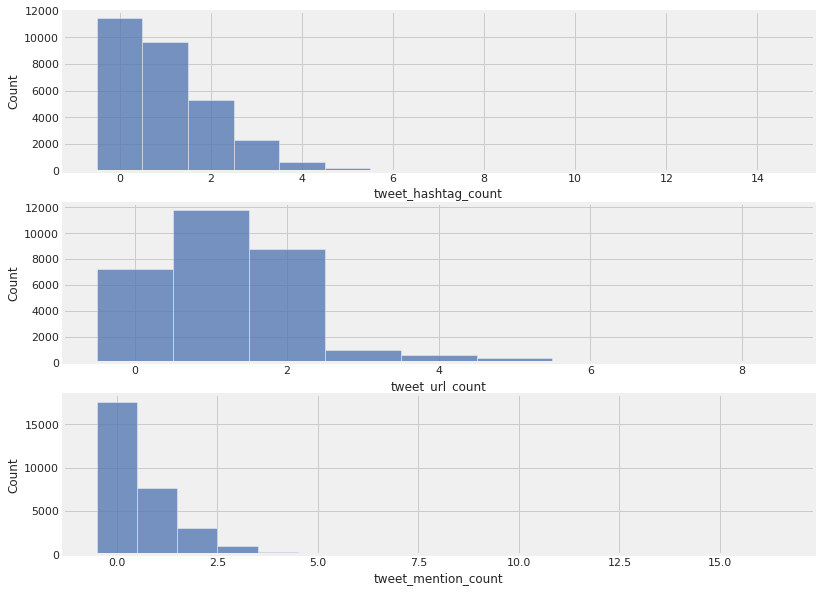

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

sns.histplot(x = 'tweet_hashtag_count', data = train_tweets, discrete = True, ax = axs[0]);
sns.histplot(x = 'tweet_url_count', data = train_tweets, discrete = True, ax = axs[1]);
sns.histplot(x = 'tweet_mention_count', data = train_tweets, discrete = True, ax = axs[2]);

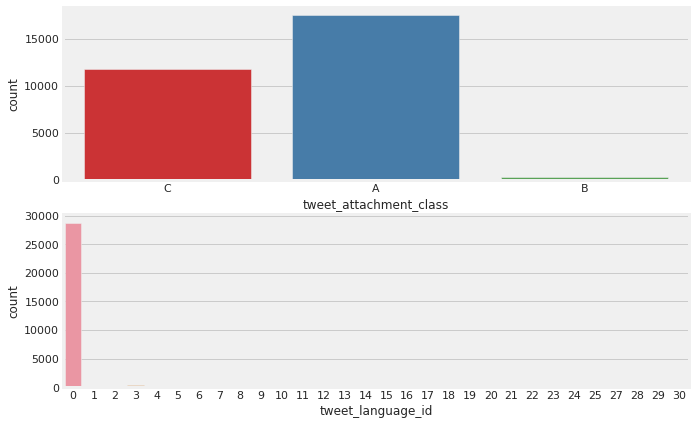

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.countplot(x = 'tweet_attachment_class', data = train_tweets, palette="Set1", ax = axs[0]);
sns.countplot(x = 'tweet_language_id', data = train_tweets, ax = axs[1]);

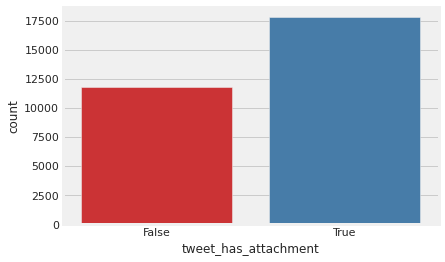

In [ ]:
sns.countplot(x = 'tweet_has_attachment', data = train_tweets, palette="Set1");

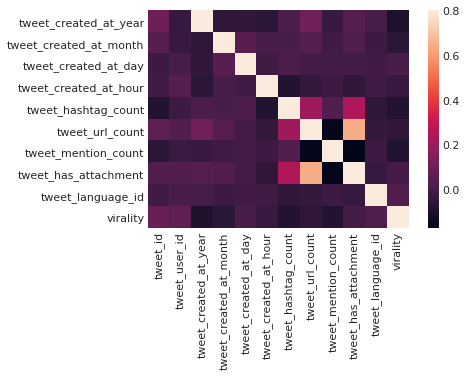

In [ ]:
corrmat = train_tweets.corr()[2:] 
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
df_corr = train_tweets.corr()['virality'][2:-1]
top_features = df_corr.sort_values(ascending=False)
top_features

tweet_language_id         0.030416
tweet_created_at_day      0.017518
tweet_has_attachment      0.005401
tweet_created_at_hour    -0.028583
tweet_url_count          -0.047833
tweet_created_at_month   -0.063757
tweet_mention_count      -0.081958
tweet_hashtag_count      -0.083262
tweet_created_at_year    -0.096487
Name: virality, dtype: float64

## Eda on users data

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                52 non-null     int64
 1   user_like_count        52 non-null     int64
 2   user_followers_count   52 non-null     int64
 3   user_following_count   52 non-null     int64
 4   user_listed_on_count   52 non-null     int64
 5   user_has_location      52 non-null     bool 
 6   user_tweet_count       52 non-null     int64
 7   user_has_url           52 non-null     bool 
 8   user_verified          52 non-null     int64
 9   user_created_at_year   52 non-null     int64
 10  user_created_at_month  52 non-null     int64
dtypes: bool(2), int64(9)
memory usage: 3.9 KB


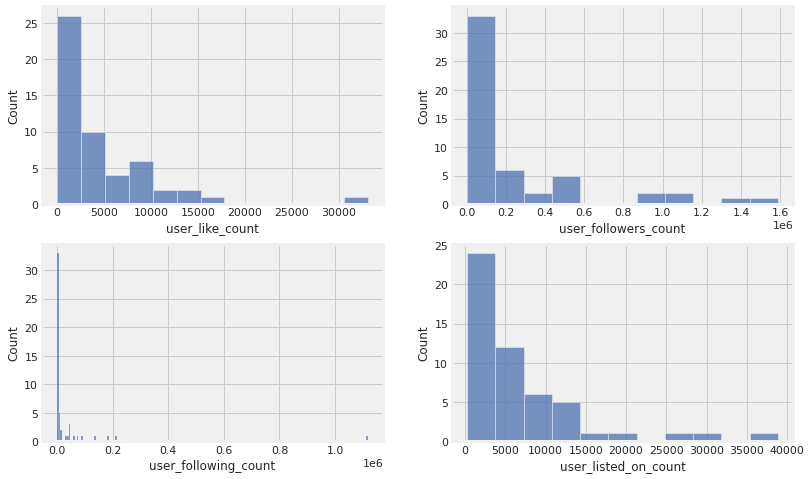

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(users, x = 'user_like_count', ax = axs[0,0]);
sns.histplot(users, x = 'user_followers_count', ax = axs[0,1]);
sns.histplot(users, x = 'user_following_count', ax = axs[1,0]);
sns.histplot(users, x = 'user_listed_on_count', ax = axs[1,1]);

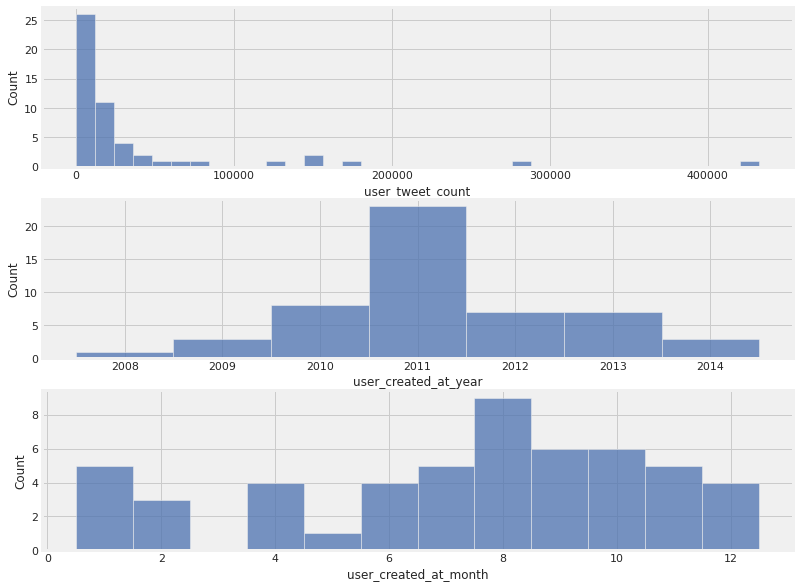

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

sns.histplot(users, x = 'user_tweet_count', ax = axs[0]);
sns.histplot(users, x = 'user_created_at_year', discrete = True, ax = axs[1]);
sns.histplot(users, x = 'user_created_at_month', discrete = True, ax = axs[2]);

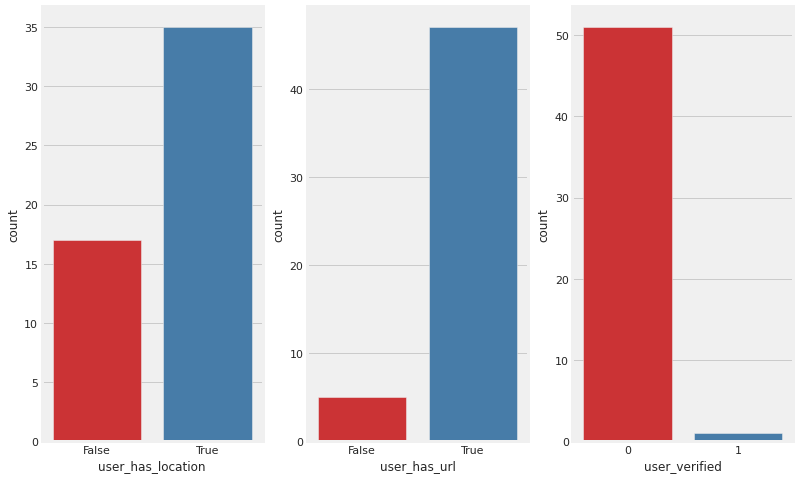

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))

sns.countplot(x = 'user_has_location', data = users, ax = axs[0], palette="Set1");
sns.countplot(x = 'user_has_url', data = users, ax = axs[1], palette="Set1");
sns.countplot(x = 'user_verified', data = users, ax = axs[2], palette="Set1");

# Data Preprocessing

## Dealing with missing data

In [ ]:
missing_cols(users)

no missing values


In [ ]:
missing_cols(train_tweets)

tweet_topic_ids => 4285 [14.46%]


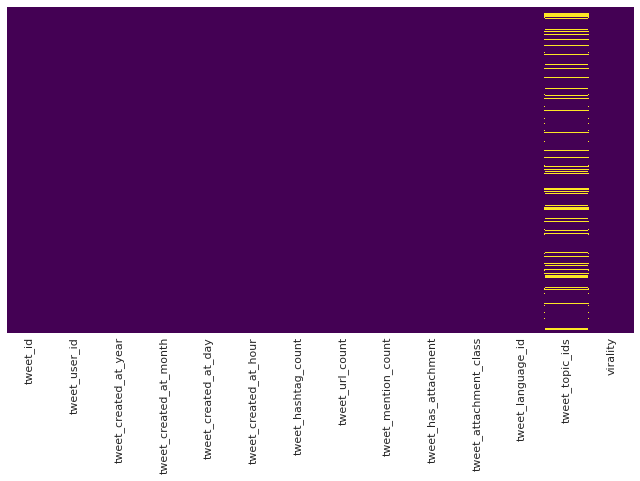

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_tweets.isnull(), yticklabels=False, cmap='viridis', cbar=False);

In [ ]:
train_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)
missing_cols(train_tweets)

no missing values


In [ ]:
# train_tweets.tweet_hashtag_count.value_counts()
# train_tweets.tweet_url_count.value_counts()
# train_tweets.tweet_mention_count.value_counts()

# convert floats to ints
cols = ['tweet_hashtag_count', 'tweet_url_count', 'tweet_mention_count']
train_tweets[cols] = train_tweets[cols].applymap(np.int64)
train_tweets[cols].head()

,tweet_hashtag_count,tweet_url_count,tweet_mention_count
0,2,1,0
1,0,1,0
2,2,3,0
3,0,1,1
4,2,1,0


## one hot encoding

In [ ]:
topic_ids = (
    train_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

In [ ]:
year = pd.get_dummies(train_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(train_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(train_tweets.tweet_created_at_day, prefix='day')
attachment = pd.get_dummies(train_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(train_tweets.tweet_language_id, prefix='language')

In [ ]:
## Cyclical encoding
sin_hour = np.sin(2*np.pi*train_tweets['tweet_created_at_hour']/24.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*train_tweets['tweet_created_at_hour']/24.0)
cos_hour.name = 'cos_hour'

In [ ]:
columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
               ]

dfs = [topic_ids, year, month, day, attachment, language, 
       sin_hour, cos_hour]

train_tweets_final = train_tweets.drop(columns_drop, 1).join(dfs)

train_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,virality,topic_id_0,topic_id_100,topic_id_101,topic_id_104,topic_id_111,topic_id_112,topic_id_118,topic_id_119,topic_id_120,topic_id_121,topic_id_122,topic_id_125,topic_id_126,topic_id_127,topic_id_147,topic_id_148,topic_id_149,topic_id_150,topic_id_151,topic_id_152,topic_id_153,topic_id_155,topic_id_156,topic_id_163,topic_id_165,topic_id_169,topic_id_170,topic_id_171,topic_id_172,topic_id_36,topic_id_37,topic_id_39,topic_id_43,...,day_27,day_28,day_29,day_30,day_31,attatchment_A,attatchment_B,attatchment_C,language_0,language_1,language_2,language_3,language_4,language_5,language_6,language_7,language_8,language_9,language_10,language_11,language_12,language_13,language_14,language_15,language_16,language_17,language_18,language_19,language_20,language_21,language_22,language_23,language_24,language_25,language_27,language_28,language_29,language_30,sin_hour,cos_hour
0,34698,10,2,1,0,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.707107,0.707107
1,24644,4,0,1,0,False,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1.000000
2,36321,54,2,3,0,True,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.707107,-0.707107
3,2629,42,0,1,1,True,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.965926,-0.258819
4,28169,32,2,1,0,True,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.965926,-0.258819


## one hot encoding on users

In [ ]:
year = pd.get_dummies(users.user_created_at_year, prefix='year')
month = pd.get_dummies(users.user_created_at_month , prefix='month')
user_verified = pd.get_dummies(users.user_verified, prefix='verified')

columns_drop = [
                "user_created_at_year",
                "user_created_at_month",
                "user_verified"
              ]

dfs = [
        year,
        month,
        user_verified
      ]

users_final = users.drop(columns_drop, 1).join(dfs)

users_final.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,month_1,month_2,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,verified_0,verified_1
0,0,1164,48720,70469,5956,True,14122,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,3914,85361,2171,5943,False,6957,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,2,8292,200944,1416,8379,True,83485,True,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,3,1770,15385,4572,1866,True,12265,True,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,4,15311,459083,1021,7368,False,121193,False,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


## feature selection

In [ ]:
# create new data frame that matches row number between train tweets and vectorized media
vectorized_media_df = pd.merge(train_tweets,train_tweets_vectorized_media, on ='tweet_id', how = 'right')
vectorized_media_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_media_df.head()

,virality,media_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,img_feature_8,img_feature_9,img_feature_10,img_feature_11,img_feature_12,img_feature_13,img_feature_14,img_feature_15,img_feature_16,img_feature_17,img_feature_18,img_feature_19,img_feature_20,img_feature_21,img_feature_22,img_feature_23,img_feature_24,img_feature_25,img_feature_26,img_feature_27,img_feature_28,img_feature_29,img_feature_30,img_feature_31,img_feature_32,img_feature_33,img_feature_34,img_feature_35,img_feature_36,img_feature_37,...,img_feature_2008,img_feature_2009,img_feature_2010,img_feature_2011,img_feature_2012,img_feature_2013,img_feature_2014,img_feature_2015,img_feature_2016,img_feature_2017,img_feature_2018,img_feature_2019,img_feature_2020,img_feature_2021,img_feature_2022,img_feature_2023,img_feature_2024,img_feature_2025,img_feature_2026,img_feature_2027,img_feature_2028,img_feature_2029,img_feature_2030,img_feature_2031,img_feature_2032,img_feature_2033,img_feature_2034,img_feature_2035,img_feature_2036,img_feature_2037,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,1,00001_00000,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,0.00027,0.424207,0.000000,0.372124,0.031332,0.041069,0.000000,0.209875,0.232068,0.003567,0.185193,0.096734,0.127461,0.005552,0.000435,0.429719,0.024739,0.000051,0.000842,0.115226,0.000000,0.026856,0.000000,0.031253,0.032772,0.051137,0.026097,0.962891,0.132004,0.158875,...,0.000480,0.000000,0.018373,0.327092,0.079089,0.360097,0.002562,1.116611,0.054391,0.086378,0.045496,0.030632,0.000000,0.000000,0.000000,0.165220,0.000000,0.059310,0.111803,0.000000,0.109110,0.025834,0.235375,0.078341,0.131708,0.013988,0.000000,0.025960,0.015760,0.266088,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,2,00004_00003,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,0.00000,0.191951,0.003372,0.000000,0.009363,0.000000,0.000000,0.012317,0.016527,0.130308,0.000000,0.000000,0.303246,0.000000,0.307988,0.011478,0.044807,0.208410,0.043399,0.118079,0.000222,0.083115,0.000000,0.634716,0.000000,0.014040,0.090266,0.000000,0.127964,0.189758,...,0.000000,0.001796,0.000000,0.251383,0.021052,0.802314,0.027913,0.335493,0.017326,0.000000,0.026515,0.056399,0.030597,0.082174,0.003829,0.083139,0.003266,0.249968,0.304901,0.004793,0.028569,0.000000,0.069980,0.007251,0.194076,0.000000,0.124188,0.000000,0.691953,0.009337,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,1,00005_00004,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,0.00000,0.040884,0.009688,0.000000,0.000000,0.000000,0.074692,0.018211,0.233618,0.039807,0.000000,0.000000,0.169830,0.000000,0.045755,0.028518,0.000000,0.259838,0.117726,0.017544,0.018106,0.000000,0.019969,0.257562,0.000000,0.006338,0.000000,0.000000,0.090963,0.746206,...,0.000000,0.000000,0.032314,0.000000,0.000000,0.143607,0.371495,0.199860,0.192786,0.000000,0.401853,0.021595,0.033472,0.164238,0.085964,0.293521,0.000000,0.082590,0.020819,0.001283,0.009182,0.000000,0.295073,0.000000,0.300424,0.228981,0.109332,0.032641,0.263165,0.000992,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,1,00008_00007,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,0.00000,0.040679,0.027965,0.000000,0.001766,0.014541,0.000000,0.010728,0.147126,0.574918,0.000000,0.126482,0.096826,0.040340,0.005732,0.000296,0.000000,0.081848,0.000000,0.001031,0.114108,0.000000,0.000000,0.702560,0.000000,0.307037,0.290887,0.003196,0.093841,0.257387,...,0.214097,0.000000,0.004700,0.005008,0.000000,0.540658,0.035425,0.069549,0.197432,0.023377,0.010510,0.000000,0.023421,0.000000,0.029902,0.067589,0.080281,0.005246,0.000000,0.000000,0.007966,0.000000,0.064383,0.255950,0.330105,0.000000

train_tweets_vectorized_media  

In [ ]:
# Set the target as well as dependent variables from image data.
y = vectorized_media_df['virality']
x = vectorized_media_df.loc[:, vectorized_media_df.columns.str.contains("img_")] 

# Run Lasso regression for feature selection.
sel_model = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  116.57981933699998


Counter({False: 1, True: 2047})

In [ ]:
media_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_media_final = pd.concat([train_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
train_tweets_media_final.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,img_feature_8,img_feature_9,img_feature_10,img_feature_11,img_feature_12,img_feature_13,img_feature_14,img_feature_15,img_feature_16,img_feature_17,img_feature_18,img_feature_19,img_feature_20,img_feature_21,img_feature_22,img_feature_23,img_feature_24,img_feature_25,img_feature_26,img_feature_27,img_feature_28,img_feature_29,img_feature_30,img_feature_31,img_feature_32,img_feature_33,img_feature_34,img_feature_35,img_feature_36,img_feature_37,...,img_feature_2008,img_feature_2009,img_feature_2010,img_feature_2011,img_feature_2012,img_feature_2013,img_feature_2014,img_feature_2015,img_feature_2016,img_feature_2017,img_feature_2018,img_feature_2019,img_feature_2020,img_feature_2021,img_feature_2022,img_feature_2023,img_feature_2024,img_feature_2025,img_feature_2026,img_feature_2027,img_feature_2028,img_feature_2029,img_feature_2030,img_feature_2031,img_feature_2032,img_feature_2033,img_feature_2034,img_feature_2035,img_feature_2036,img_feature_2037,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,0.00027,0.424207,0.000000,0.372124,0.031332,0.041069,0.000000,0.209875,0.232068,0.003567,0.185193,0.096734,0.127461,0.005552,0.000435,0.429719,0.024739,0.000051,0.000842,0.115226,0.000000,0.026856,0.000000,0.031253,0.032772,0.051137,0.026097,0.962891,0.132004,0.158875,...,0.000480,0.000000,0.018373,0.327092,0.079089,0.360097,0.002562,1.116611,0.054391,0.086378,0.045496,0.030632,0.000000,0.000000,0.000000,0.165220,0.000000,0.059310,0.111803,0.000000,0.109110,0.025834,0.235375,0.078341,0.131708,0.013988,0.000000,0.025960,0.015760,0.266088,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,0.00000,0.191951,0.003372,0.000000,0.009363,0.000000,0.000000,0.012317,0.016527,0.130308,0.000000,0.000000,0.303246,0.000000,0.307988,0.011478,0.044807,0.208410,0.043399,0.118079,0.000222,0.083115,0.000000,0.634716,0.000000,0.014040,0.090266,0.000000,0.127964,0.189758,...,0.000000,0.001796,0.000000,0.251383,0.021052,0.802314,0.027913,0.335493,0.017326,0.000000,0.026515,0.056399,0.030597,0.082174,0.003829,0.083139,0.003266,0.249968,0.304901,0.004793,0.028569,0.000000,0.069980,0.007251,0.194076,0.000000,0.124188,0.000000,0.691953,0.009337,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,0.00000,0.040884,0.009688,0.000000,0.000000,0.000000,0.074692,0.018211,0.233618,0.039807,0.000000,0.000000,0.169830,0.000000,0.045755,0.028518,0.000000,0.259838,0.117726,0.017544,0.018106,0.000000,0.019969,0.257562,0.000000,0.006338,0.000000,0.000000,0.090963,0.746206,...,0.000000,0.000000,0.032314,0.000000,0.000000,0.143607,0.371495,0.199860,0.192786,0.000000,0.401853,0.021595,0.033472,0.164238,0.085964,0.293521,0.000000,0.082590,0.020819,0.001283,0.009182,0.000000,0.295073,0.000000,0.300424,0.228981,0.109332,0.032641,0.263165,0.000992,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,0.00000,0.040679,0.027965,0.000000,0.001766,0.014541,0.000000,0.010728,0.147126,0.574918,0.000000,0.126482,0.096826,0.040340,0.005732,0.000296,0.000000,0.081848,0.000000,0.001031,0.114108,0.000000,0.000000,0.702560,0.000000,0.307037,0.290887,0.003196,0.093841,0.257387,...,0.214097,0.000000,0.004700,0.005008,0.000000,0.540658,0.035425,0.069549,0.197432,0.023377,0.010510,0.000000,0.023421,0.000000,0.029902,0.067589,0.080281,0.005246,0.000000,0.000000,0.007966,0.000000,0.064383,0.255950,0.330105,0.000000

train_tweets_vectorized_text  


In [ ]:
# create new data frame that matches row number between train tweets and vectorized media
vectorized_text_df = pd.merge(train_tweets,train_tweets_vectorized_text, on ='tweet_id', how = 'right')
vectorized_text_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_text_df.head()

,virality,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_728,feature_729,feature_730,feature_731,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,0.120231,-0.245443,0.199461,-0.154236,-0.200109,-0.206436,0.270252,-0.142692,-0.102078,0.157226,-0.334515,-0.264958,-0.112983,-0.293211,-0.253694,-0.104198,0.056506,-0.231244,0.152571,0.206752,-0.150545,0.112063,-0.129411,-0.224150,-0.175330,-0.165828,-0.066047,-0.159027,0.009872,0.019299,...,0.039782,-0.174679,0.148821,-0.192575,-0.114211,0.496451,0.040274,-0.142680,0.169754,-0.075535,-0.117306,0.261488,0.240786,-0.150380,-0.080656,0.310319,0.042854,0.048131,-0.172710,0.135926,-0.043390,-0.208796,0.040137,-0.190645,-0.096934,-0.009036,0.284776,0.338148,-0.440536,-0.090837,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,0.135007,-0.192705,0.252616,-0.135662,-0.201412,-0.183382,0.173640,-0.103182,-0.074723,0.234004,-0.283560,-0.120644,-0.063076,-0.248546,-0.224326,-0.176795,0.061400,-0.243843,0.226394,0.101096,-0.077593,0.057844,-0.086949,-0.239860,-0.303655,-0.223538,-0.041548,-0.162694,0.005842,0.053615,...,0.151876,-0.153876,0.272216,-0.265888,-0.124845,0.500886,-0.053478,-0.159796,0.102271,0.032116,-0.034348,0.292187,0.236578,-0.006660,-0.113676,0.249192,0.048188,-0.055551,-0.037698,0.148909,0.064823,-0.270230,0.003926,-0.207080,-0.062248,-0.056531,0.188629,0.366379,-0.511710,-0.025049,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,2,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,0.101362,-0.238145,0.173951,-0.102029,-0.181864,-0.214877,0.186110,-0.032114,-0.143620,0.175421,-0.260034,-0.103828,-0.122353,-0.316970,-0.289015,-0.215771,0.027695,-0.254362,0.160985,0.040491,-0.019251,0.156431,-0.089619,-0.204530,-0.155480,-0.207329,-0.044228,-0.094432,-0.054102,-0.069460,...,0.013487,-0.145385,0.251336,-0.243751,-0.218401,0.557650,-0.032927,-0.233999,0.107764,-0.054706,-0.151404,0.268172,0.148024,0.066601,-0.126532,0.235418,0.013908,0.107383,-0.114999,0.242328,0.062410,-0.122995,0.026454,-0.118704,-0.025266,0.015129,0.252958,0.273657,-0.522295,-0.049114,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,1,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,0.056506,-0.180725,0.183492,-0.055121,-0.205312,-0.267817,0.152828,-0.026461,-0.150457,0.253863,-0.289086,-0.194721,-0.073793,-0.313012,-0.311311,-0.254014,-0.055075,-0.147885,0.179036,0.120235,-0.005531,0.080192,-0.229052,-0.137060,-0.281633,-0.225555,-0.010621,-0.105480,-0.135987,-0.034342,...,0.058002,-0.146499,0.203021,-0.242434,-0.169852,0.488979,0.018102,-0.178110,0.155078,-0.020591,-0.145490,0.284350,0.186599,0.037712,-0.143745,0.180907,-0.023579,0.016043,-0.097705,0.168376,0.072525,-0.184797,0.048695,-0.136387,-0.102923,-0.042237,0.235340,0.317434,-0.532257,-0.036280,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,1,0.144889,-0.084

In [ ]:
# Set the target as well as dependent variables from image data.
y = vectorized_text_df['virality']
x = vectorized_text_df.loc[:, train_tweets_vectorized_text.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  361.243360126


Counter({False: 94, True: 674})

In [ ]:
text_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_text_final = pd.concat([train_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)
train_tweets_text_final.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_18,feature_19,feature_21,feature_22,feature_23,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,...,feature_723,feature_724,feature_726,feature_727,feature_728,feature_730,feature_732,feature_733,feature_734,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,0.120231,-0.245443,-0.154236,-0.200109,-0.206436,0.270252,-0.142692,0.157226,-0.334515,-0.112983,-0.293211,-0.253694,0.056506,-0.231244,0.152571,0.206752,-0.150545,0.112063,-0.129411,-0.224150,-0.175330,-0.165828,-0.066047,-0.159027,0.009872,0.019299,-0.002647,0.342013,-0.187480,0.036805,...,0.083628,-0.087576,-0.061539,-0.193925,0.039782,0.148821,-0.114211,0.496451,0.040274,0.169754,-0.075535,-0.117306,0.261488,0.240786,-0.150380,-0.080656,0.042854,0.048131,-0.172710,0.135926,-0.043390,-0.208796,0.040137,-0.190645,-0.096934,-0.009036,0.284776,0.338148,-0.440536,-0.090837,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,0.135007,-0.192705,-0.135662,-0.201412,-0.183382,0.173640,-0.103182,0.234004,-0.283560,-0.063076,-0.248546,-0.224326,0.061400,-0.243843,0.226394,0.101096,-0.077593,0.057844,-0.086949,-0.239860,-0.303655,-0.223538,-0.041548,-0.162694,0.005842,0.053615,-0.017521,0.519362,-0.256842,0.026188,...,0.051597,-0.016395,0.054306,-0.163528,0.151876,0.272216,-0.124845,0.500886,-0.053478,0.102271,0.032116,-0.034348,0.292187,0.236578,-0.006660,-0.113676,0.048188,-0.055551,-0.037698,0.148909,0.064823,-0.270230,0.003926,-0.207080,-0.062248,-0.056531,0.188629,0.366379,-0.511710,-0.025049,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,0.101362,-0.238145,-0.102029,-0.181864,-0.214877,0.186110,-0.032114,0.175421,-0.260034,-0.122353,-0.316970,-0.289015,0.027695,-0.254362,0.160985,0.040491,-0.019251,0.156431,-0.089619,-0.204530,-0.155480,-0.207329,-0.044228,-0.094432,-0.054102,-0.069460,0.009704,0.531497,-0.277437,0.108438,...,-0.059980,0.028263,0.021479,-0.215399,0.013487,0.251336,-0.218401,0.557650,-0.032927,0.107764,-0.054706,-0.151404,0.268172,0.148024,0.066601,-0.126532,0.013908,0.107383,-0.114999,0.242328,0.062410,-0.122995,0.026454,-0.118704,-0.025266,0.015129,0.252958,0.273657,-0.522295,-0.049114,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,0.056506,-0.180725,-0.055121,-0.205312,-0.267817,0.152828,-0.026461,0.253863,-0.289086,-0.073793,-0.313012,-0.311311,-0.055075,-0.147885,0.179036,0.120235,-0.005531,0.080192,-0.229052,-0.137060,-0.281633,-0.225555,-0.010621,-0.105480,-0.135987,-0.034342,0.005922,0.500443,-0.246112,0.015544,...,-0.001471,-0.079780,-0.010137,-0.128420,0.058002,0.203021,-0.169852,0.488979,0.018102,0.155078,-0.020591,-0.145490,0.284350,0.186599,0.037712,-0.143745,-0.023579,0.016043,-0.097705,0.168376,0.072525,-0.184797,0.048695,-0.136387,-0.102923,-0.042237,0.235340,0.317434,-0.532257,-0.036280,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.1

In [ ]:
# Find the median of virality for each user to reduce features for user vectorized
# description and profile
average_virality_df =train_tweets.groupby('tweet_user_id').agg(pd.Series.median)['virality']

descriptions_df = pd.merge(average_virality_df, user_vectorized_descriptions, left_on ='tweet_user_id', right_on = 'user_id', how = 'right')
profile_images_df = pd.merge(average_virality_df, user_vectorized_profile_images, left_on ='tweet_user_id', right_on = 'user_id', how = 'right')
descriptions_df.head()

,virality,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,...,feature_728,feature_729,feature_730,feature_731,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,0.047779,0.041972,-0.211500,0.157389,-0.119609,-0.167288,-0.183701,0.162600,-0.118144,-0.160549,0.206170,-0.349808,-0.180516,-0.075424,-0.228215,-0.227588,-0.206130,0.097065,-0.201940,0.113164,0.115008,-0.025116,0.063400,-0.129166,-0.154574,-0.219841,-0.185450,-0.099904,-0.084291,-0.044961,...,0.083985,-0.157461,0.285158,-0.197924,-0.163785,0.535255,0.027747,-0.155363,0.146396,-0.090979,-0.170317,0.254166,0.260563,-0.071186,-0.140582,0.310176,0.083907,-0.034472,-0.172740,0.126395,-0.004203,-0.177539,0.038244,-0.188420,-0.080583,0.065391,0.265358,0.307018,-0.494297,-0.142920,0.238264,-0.315408,-0.159851,-0.003840,0.213492,0.002498,0.177574,-0.136515,-0.012882,0.017399
1,2,1,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,0.007423,0.030401,-0.216736,0.183259,-0.069264,-0.236452,-0.209206,0.174043,-0.121529,-0.150529,0.228872,-0.336505,-0.204807,-0.152244,-0.307261,-0.216196,-0.265559,0.077822,-0.346440,0.154961,0.165459,-0.000246,0.065532,-0.173314,-0.191337,-0.143802,-0.223451,-0.067280,-0.124719,-0.160180,...,0.036054,-0.140715,0.224058,-0.174127,-0.159510,0.531637,-0.003619,-0.117995,0.093102,-0.086952,-0.189147,0.209478,0.246669,-0.043450,-0.158822,0.295335,0.058998,-0.008168,-0.144616,0.219429,0.049639,-0.211484,0.026302,-0.199768,-0.131321,0.020595,0.304960,0.283139,-0.525245,-0.187449,0.232922,-0.314534,-0.177011,-0.041710,0.209785,-0.023427,0.158203,-0.143221,0.030484,0.081693
2,1,2,0.122312,-0.159376,-0.073417,-0.149442,-0.122684,-0.005277,-0.351233,-0.297342,-0.006010,0.083945,-0.243968,0.184267,-0.045257,-0.191175,-0.168322,0.190007,-0.150225,-0.191811,0.260278,-0.323330,-0.226146,-0.106863,-0.163877,-0.207189,-0.153667,0.090430,-0.265063,0.103507,0.147642,-0.003167,0.083048,-0.220785,-0.242494,-0.238759,-0.194130,-0.034603,0.002399,-0.173476,...,0.003421,-0.165013,0.254066,-0.213777,-0.134803,0.554688,-0.024580,-0.159201,0.116502,-0.111342,-0.140976,0.216088,0.219368,-0.052936,-0.126136,0.385574,0.039820,-0.023451,-0.120135,0.191185,0.016503,-0.223201,0.051937,-0.162366,-0.111131,0.047493,0.281597,0.339442,-0.440569,-0.059945,0.173621,-0.292476,-0.185078,-0.026784,0.184902,0.009539,0.217004,-0.091951,0.025304,0.058501
3,1,3,0.160509,-0.137915,-0.002524,-0.034696,0.028126,0.056299,-0.365196,-0.259523,-0.037929,0.104135,-0.206807,0.194023,-0.105497,-0.277824,-0.154094,0.185838,-0.147508,-0.183590,0.282249,-0.251785,-0.132236,-0.152960,-0.293629,-0.165441,-0.207462,0.033447,-0.275356,0.135713,0.106392,-0.023706,0.049851,-0.122355,-0.158445,-0.189165,-0.210765,0.043706,-0.079914,-0.075443,...,0.034914,-0.239188,0.287563,-0.316668,-0.133856,0.503008,-0.039165,-0.090734,0.055525,-0.082432,-0.095903,0.214028,0.232646,-0.098938,-0.117663,0.290847,-0.023200,-0.031113,-0.156534,0.187953,0.039809,-0.193605,0.044424,-0.119147,0.001465,-0.090170,0.228475,0.299477,-0.412852,-0.191728,0.205752,-0.300688,-0.133753,0.002206,0.245214,-0.056659,0.152064,-0.180211,0.022327,0.014688
4,3,4,0.099192,-0.140809,-0.012423,-0.150097,-0.1201

user_vectorized_descriptions

In [ ]:
# Set the target as well as dependent variables from image data.
y = descriptions_df['virality']
x = descriptions_df.loc[:, descriptions_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  0.011382698000033997


Counter({False: 768})

In [ ]:
desc_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_descriptions_final = pd.concat([user_vectorized_descriptions[['user_id']], desc_ind_df], axis=1)
user_descriptions_final.head()

,user_id
0,0
1,1
2,2
3,3
4,4


user_vectorized_profile_images

In [ ]:
# Set the target as well as dependent variables from image data.
y = profile_images_df['virality']
x = profile_images_df.loc[:, profile_images_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  0.02281839799991303


Counter({False: 2002, True: 46})

In [ ]:
user_prof_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_profile_images_final = pd.concat([user_vectorized_profile_images[['user_id']], user_prof_ind_df], axis=1)
user_profile_images_final.head()

,user_id,feature_17,feature_27,feature_40,feature_61,feature_72,feature_86,feature_173,feature_317,feature_414,feature_479,feature_502,feature_517,feature_528,feature_534,feature_541,feature_575,feature_655,feature_665,feature_711,feature_731,feature_746,feature_751,feature_806,feature_866,feature_1013,feature_1070,feature_1103,feature_1227,feature_1263,feature_1312,feature_1322,feature_1470,feature_1518,feature_1574,feature_1615,feature_1658,feature_1791,feature_1813,feature_1816,feature_1822,feature_1864,feature_1918,feature_1922,feature_1950,feature_1961,feature_1969
0,0,0.119278,0.525636,0.900191,0.083202,0.329536,0.000521,0.000000,0.627162,0.091552,1.814183,0.715075,0.638779,0.788213,0.005030,0.583198,0.000000,1.112280,0.662897,0.219225,0.358670,0.027402,0.042079,0.508691,1.142108,0.614082,0.149050,0.324807,1.437681,0.288540,0.457674,1.086635,0.547103,1.218405,0.762789,0.034371,0.590424,0.033612,0.107358,0.372768,0.007634,0.932529,0.114959,1.013090,0.649760,0.084254,1.045067
1,1,0.000000,0.117184,0.357163,0.095469,0.855587,0.198007,0.393067,1.099741,0.066106,1.472832,0.241020,0.779714,0.909803,0.209311,0.000000,0.040874,0.893271,0.498627,0.385898,0.276677,0.724167,0.000000,0.892407,1.431419,0.575161,0.481299,0.000000,0.973962,0.008487,1.301407,1.041259,0.824481,2.199537,0.608887,0.047531,0.108944,0.133920,0.386295,0.014066,0.692967,0.749812,0.009956,0.044573,0.585450,0.136455,0.490154
2,2,0.000446,0.315113,0.409932,0.027620,1.140514,0.000000,0.000000,0.779874,0.061270,1.342390,0.000000,0.056189,0.040858,0.000000,0.769977,0.876512,0.101724,0.182883,0.343574,0.027560,0.001476,0.000000,0.487910,0.582645,1.299646,0.005579,0.000067,0.413469,0.000000,0.178606,0.000000,0.588527,1.068521,0.007840,0.108560,0.003820,0.120005,0.069618,0.000000,0.077035,0.110357,0.041843,0.620970,0.327903,0.003597,0.305369
3,3,0.166473,0.024092,0.081909,0.005259,0.864800,0.000000,0.000000,0.739145,0.083874,0.714039,0.262326,0.417069,0.009370,0.321530,0.859565,1.420485,0.438797,0.140854,0.467226,0.039689,0.009919,0.000000,0.719414,0.731161,1.093207,0.969776,0.000000,0.317578,0.014479,0.868211,0.697263,0.714434,0.982409,0.029773,0.156120,0.226587,0.184952,0.094760,0.046148,0.088233,0.332397,0.135303,0.062701,0.294951,0.000000,0.285678
4,4,0.349089,0.544103,1.188643,0.183290,0.792999,0.244120,0.246967,0.664849,0.181680,1.696521,0.333744,0.243706,0.495019,0.098840,0.767536,0.000000,0.236177,0.701704,0.125321,0.064673,0.024742,0.543757,0.332432,1.733089,0.901957,0.113262,1.285948,1.840017,0.904064,0.269438,0.914268,0.291749,1.395496,0.717204,0.000000,0.929284,0.173362,0.026295,0.135455,0.000000,1.579148,0.016151,0.113244,0.672702,0.875126,0.149596


In [ ]:
print(train_tweets_final.shape)
print(train_tweets_media_final.shape) # join on tweet id
print(train_tweets_text_final.shape) # join on tweet id
print(users_final.shape) # join on user_id
print(user_profile_images_final.shape) # join on user_id

(29625, 151)
(21010, 2049)
(29625, 675)
(52, 28)
(52, 47)


In [ ]:
# media final doesn't have equal rows, so I have to group by tweet_id (since
#  there are multiple media id for a single tweet), average the features (naive way
# but this is an example to do this) and then I can join it with train_tweets
media_df =train_tweets_media_final.groupby('tweet_id').mean()

In [ ]:
# tweets_vectorized_text and user_vectorized_profile_images has same column 
# names which will cause problems when merging

# rename columns in tweets_vectorized_text

cols = train_tweets_text_final.columns[train_tweets_text_final.columns.str.contains('feature_')]
train_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)
train_tweets_text_final.head()

,tweet_id,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,text_feature_9,text_feature_10,text_feature_12,text_feature_13,text_feature_14,text_feature_15,text_feature_16,text_feature_18,text_feature_19,text_feature_21,text_feature_22,text_feature_23,text_feature_25,text_feature_26,text_feature_27,text_feature_28,text_feature_29,text_feature_30,text_feature_31,text_feature_32,text_feature_33,text_feature_34,text_feature_35,text_feature_36,text_feature_37,text_feature_38,text_feature_39,text_feature_40,text_feature_41,text_feature_42,...,text_feature_723,text_feature_724,text_feature_726,text_feature_727,text_feature_728,text_feature_730,text_feature_732,text_feature_733,text_feature_734,text_feature_736,text_feature_737,text_feature_738,text_feature_739,text_feature_740,text_feature_741,text_feature_742,text_feature_744,text_feature_745,text_feature_746,text_feature_747,text_feature_748,text_feature_749,text_feature_750,text_feature_751,text_feature_752,text_feature_753,text_feature_754,text_feature_755,text_feature_756,text_feature_757,text_feature_758,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,0.120231,-0.245443,-0.154236,-0.200109,-0.206436,0.270252,-0.142692,0.157226,-0.334515,-0.112983,-0.293211,-0.253694,0.056506,-0.231244,0.152571,0.206752,-0.150545,0.112063,-0.129411,-0.224150,-0.175330,-0.165828,-0.066047,-0.159027,0.009872,0.019299,-0.002647,0.342013,-0.187480,0.036805,...,0.083628,-0.087576,-0.061539,-0.193925,0.039782,0.148821,-0.114211,0.496451,0.040274,0.169754,-0.075535,-0.117306,0.261488,0.240786,-0.150380,-0.080656,0.042854,0.048131,-0.172710,0.135926,-0.043390,-0.208796,0.040137,-0.190645,-0.096934,-0.009036,0.284776,0.338148,-0.440536,-0.090837,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,0.135007,-0.192705,-0.135662,-0.201412,-0.183382,0.173640,-0.103182,0.234004,-0.283560,-0.063076,-0.248546,-0.224326,0.061400,-0.243843,0.226394,0.101096,-0.077593,0.057844,-0.086949,-0.239860,-0.303655,-0.223538,-0.041548,-0.162694,0.005842,0.053615,-0.017521,0.519362,-0.256842,0.026188,...,0.051597,-0.016395,0.054306,-0.163528,0.151876,0.272216,-0.124845,0.500886,-0.053478,0.102271,0.032116,-0.034348,0.292187,0.236578,-0.006660,-0.113676,0.048188,-0.055551,-0.037698,0.148909,0.064823,-0.270230,0.003926,-0.207080,-0.062248,-0.056531,0.188629,0.366379,-0.511710,-0.025049,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,0.101362,-0.238145,-0.102029,-0.181864,-0.214877,0.186110,-0.032114,0.175421,-0.260034,-0.122353,-0.316970,-0.289015,0.027695,-0.254362,0.160985,0.040491,-0.019251,0.156431,-0.089619,-0.204530,-0.155480,-0.207329,-0.044228,-0.094432,-0.054102,-0.069460,0.009704,0.531497,-0.277437,0.108438,...,-0.059980,0.028263,0.021479,-0.215399,0.013487,0.251336,-0.218401,0.557650,-0.032927,0.107764,-0.054706,-0.151404,0.268172,0.148024,0.066601,-0.126532,0.013908,0.107383,-0.114999,0.242328,0.062410,-0.122995,0.026454,-0.118704,-0.025266,0.015129,0.252958,0.273657,-0.522295,-0.049114,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,0.056506,-0.180725,-0.055121,-0.205312,-0.267817,0.152828,-0.026461,0.253863,-0.289086,-0.073793,-0.313012,-0.311311,-0.055075,-0.147885,0.179036,0.120235,-0.005531,0.080192,-0.229052,-0.137060,-0.281633,-0.225555,-0.010621,-0.105480,-0.135987,-0.034342,0.005922,0.500443,-0.246112,0.015544,...,-0.001471,-0.

In [ ]:
# Merge all tables based on the column 'user_id' for user data, and tweet_id
# for tweet data

# join tweets data
tweet_df = pd.merge(media_df, train_tweets_text_final, on = 'tweet_id', how = 'right')
tweet_df.fillna(0, inplace=True)

# join users data
user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# join tweets data on train_tweets
tweet_df_final = pd.merge(train_tweets_final, tweet_df, on = 'tweet_id')

# join that with the users data
final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

final_df.shape

(29625, 2946)

## preprocessing on test data

In [ ]:
missing_cols(test_tweets)

tweet_topic_ids => 1802 [14.19%]


In [ ]:
test_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)

In [ ]:
# convert floats to ints
cols = ['tweet_hashtag_count', 'tweet_url_count', 'tweet_mention_count']
test_tweets[cols] = test_tweets[cols].applymap(np.int64)
test_tweets[cols].head()

,tweet_hashtag_count,tweet_url_count,tweet_mention_count
0,5,2,0
1,0,0,1
2,0,1,0
3,0,1,1
4,2,2,0


In [ ]:
topic_ids = (
    test_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

year = pd.get_dummies(test_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(test_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(test_tweets.tweet_created_at_day, prefix='day')
attachment = pd.get_dummies(test_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(test_tweets.tweet_language_id, prefix='language')

## Cyclical encoding
sin_hour = np.sin(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
cos_hour.name = 'cos_hour'


columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
              ]

dfs = [
        topic_ids,
        year,
        month,
        day,
        attachment,
        language,
        sin_hour,
        cos_hour,
      ]

test_tweets_final = test_tweets.drop(columns_drop, 1).join(dfs)

test_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,topic_id_0,topic_id_100,topic_id_101,topic_id_104,topic_id_111,topic_id_112,topic_id_117,topic_id_118,topic_id_119,topic_id_120,topic_id_121,topic_id_122,topic_id_123,topic_id_125,topic_id_126,topic_id_127,topic_id_147,topic_id_148,topic_id_149,topic_id_150,topic_id_151,topic_id_152,topic_id_153,topic_id_155,topic_id_156,topic_id_163,topic_id_169,topic_id_170,topic_id_171,topic_id_172,topic_id_36,topic_id_37,topic_id_38,topic_id_39,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,attatchment_A,attatchment_B,attatchment_C,language_0,language_1,language_2,language_3,language_4,language_5,language_6,language_7,language_8,language_9,language_10,language_11,language_12,language_13,language_18,language_19,language_20,language_21,language_23,language_24,language_25,language_26,language_29,sin_hour,cos_hour
0,6238,13,5,2,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,-8.660254e-01
1,37458,14,0,0,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.000000,-1.836970e-16
2,23968,50,0,1,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.866025,5.000000e-01
3,24137,50,0,1,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.707107,7.071068e-01
4,8064,30,2,2,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.866025,-5.000000e-01


match number of columns between test and train

In [ ]:
cols_test = set(test_tweets_final.columns) - set(train_tweets_final.columns)
cols_test # train is missing these 4 columns from test

{'language_26', 'topic_id_117', 'topic_id_123', 'topic_id_38'}

In [ ]:
for col in cols_test:
  final_df[col] = 0

In [ ]:
# columns missing in test from train
cols_train = set(train_tweets_final.columns) - set(test_tweets_final.columns)
cols_train.remove('virality') # remove virality from columns to add to test
len(cols_train)

9

In [ ]:
for col in cols_train:
  test_tweets_final[col] = 0

In [ ]:
test_tweets_media_final = pd.concat([test_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
test_tweets_text_final = pd.concat([test_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)

media_df = test_tweets_media_final.groupby('tweet_id').mean()

cols = test_tweets_text_final.columns[test_tweets_text_final.columns.str.contains('feature_')]
test_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)

# join tweets data
tweet_df = pd.merge(media_df, test_tweets_text_final, on = 'tweet_id', how = 'right')
tweet_df.fillna(0, inplace=True)

# join users data
user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# join tweets data on train_tweets
tweet_df_final = pd.merge(test_tweets_final, tweet_df, on = 'tweet_id')

# join that with the users data
p_final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

p_final_df.shape

(12697, 2949)

In [ ]:
final_df.shape # one more than test because of virality column

(29625, 2950)

# build the Lightgbm model

In [ ]:
X = final_df.drop(['virality', 'tweet_user_id', 'tweet_id', 'user_id'], axis=1)
y = final_df['virality']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print('Training set shape ', X_train.shape)
print('Test set shape ', X_test.shape)

Training set shape  (20737, 2946)
Test set shape  (8888, 2946)


In [ ]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#prediction on the test dataset
y_pred=clf.predict(X_test)

In [ ]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6645


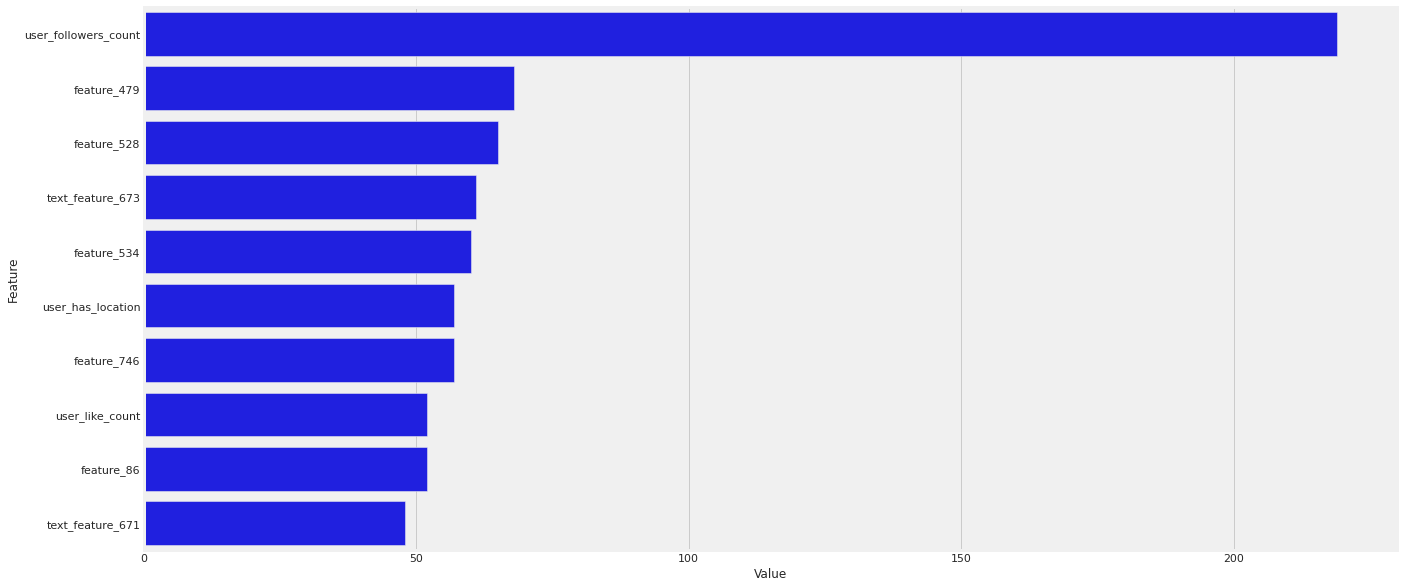

In [ ]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10], color='blue');

## Fit model to test/public data

In [ ]:
X = p_final_df.drop(['tweet_user_id', 'tweet_id', 'user_id'], axis=1)

solution = clf.predict(X)
solution_df = pd.concat([p_final_df[['tweet_id']], pd.DataFrame(solution, columns = ['virality'])], axis=1)
solution_df.head()

,tweet_id,virality
0,6238,1
1,6334,5
2,5822,1
3,6260,1
4,6162,1


In [ ]:
solution_df.to_csv('solution.csv', index=False)